In [1]:
# import libraries
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import rasterio
from rasterio import transform
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from geopy.distance import great_circle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load sota basin shapefile
river = gpd.read_file('./data/input/river_sota.shp')

In [3]:
# load sota sub basins shapefile and reproject to EPSG:4326
subs = gpd.read_file('./data/input/sub_basins_sota.shp').to_crs('EPSG:4326')

In [4]:
# load sota forest shapefile
forest = gpd.read_file('./data/input/forest_sota.shp')

In [5]:
# load sota forest shapefile
road = gpd.read_file('./data/input/road_sota.shp')

In [6]:
# load difference between theoretically homogeneous hydrological zones of sota
thhz_diff = rasterio.open('./data/output/thhz_diff.tif')

# Find main river intersection

In [7]:
# select main rivers (the ones with labeled names) in sota
main_river = river[(river['TYPE'] == 'CEP') | (river['TYPE'] == 'CEI')]

In [8]:
# define projection system
crs = 'EPSG:4326'

In [9]:
# get river intersection
s = pd.Series(main_river.geometry.values, index=main_river.index).to_dict() # create a dictionary with index as key and geometry as value

intersections = []
for i in itertools.combinations(s, 2): # for all pairwise combination of river indixes (dont do this with very large datasets..)
    i1, i2 = i
    if s[i1].intersects(s[i2]): # if they intersect
        intersections.append([i1, i2, s[i1].intersection(s[i2])]) 
        # store their indexes and intersection geometry (should be points) as a list of lists

In [10]:
# convert river intersection to geodataframe
inter_r = gpd.GeoDataFrame(pd.DataFrame(data=intersections, 
                                        columns=['first_line','second_line','geometry']),
                           geometry='geometry', crs=crs)

In [11]:
# simplify multipoints, linestrings and other geometries to points
inter_r['geometry'] = inter_r.representative_point()

# Difference between thhz pixel values and coordinates

In [12]:
# read raster band
band_diff = thhz_diff.read(1)

In [13]:
# inspect raster band by counting pixel values
values, counts = np.unique(band_diff.reshape(-1), 
                           return_counts = True, 
                           axis = 0)
pd.DataFrame(zip(values, counts), columns=['values', 'counts'])

,values,counts
0,-7.0,10
1,-6.0,203
2,-5.0,126
3,-4.0,172
4,-3.0,4582
5,-2.0,2565
6,-1.0,4603
7,0.0,2088976
8,1.0,4933
9,2.0,2544


In [14]:
# extract longitude and latitudes of list of raster pixel values
def coordinates_and_values(raster, pixel_values):
    """
    this function extracts longitude and latitudes of list of raster pixel values
    raster: load raster with rasterio
    pixel_values: list of pixel values 
    exception: pixel value must be found more than one time in raster else len of float error
    """
    df = pd.DataFrame() # create dataframe
    raster_band = raster.read(1) # read raster band
    for i in pixel_values: # iterate between list of pixel values
        rows, cols = np.where(raster_band == i) # extract row and column numbers for each pixel
        rows, cols = transform.xy(raster.transform, rows, cols) # transform row and column numbers to coordinates
        values = np.array([i] * len(rows)) # create array containing n pixel value of n coordinates
        df_i = pd.DataFrame(zip(rows, cols, values), columns=['lon','lat', 'pixel']) # create dataframe for one pixel value
        df = df.append(df_i) # append to get dataframe of lon and lat of list of pixel values
    return df

In [15]:
# execute function and rest index
thhz_value = coordinates_and_values(thhz_diff, [1, 2, 3, 4, 5, 6])
thhz_value = thhz_value.reset_index().drop('index', axis=1)

In [16]:
# only have positive values of pixels
thhz_value['pixel'] = np.abs(thhz_value['pixel'])

In [17]:
# convert dataframe to geodataframe
geometry = [Point(xy) for xy in zip(thhz_value.lon, thhz_value.lat)]
thhz_value = gpd.GeoDataFrame(thhz_value, crs=crs, geometry=geometry)

# All stations

In [18]:
# add buffer to river intersection to easily find intersection with thhz coordinates
inter_buf = inter_r
inter_buf['buffered'] = inter_r['geometry'].buffer(0.01)

<ipython-input-18-2be2517dee22>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  inter_buf['buffered'] = inter_r['geometry'].buffer(0.01)


In [19]:
# set buffered polygone as geometry
inter_buf = inter_buf.set_geometry('buffered')

In [20]:
# clip thhz coordinates with river intersection
clip = gpd.clip(thhz_value, inter_buf)

<AxesSubplot:>

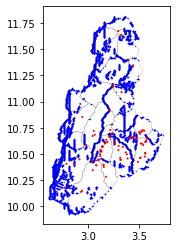

In [21]:
# plot sota sub basins, thhz coordinates and river intersection
base = subs.boundary.plot(color='black', linewidth=0.1)
inter_buf.plot(ax=base, color='red', markersize=5, zorder=2)
thhz_value.plot(ax=base, markersize=0.1, color='blue')

<AxesSubplot:>

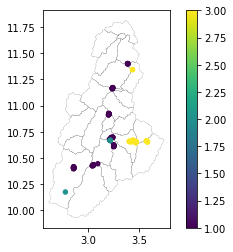

In [22]:
# plot sota sub basins and clipped points
base = subs.boundary.plot(color='black', linewidth=0.1)
clip.plot(ax=base, column='pixel', markersize=20, legend=True, zorder=2)

# Cluster and prioritize stations

In [23]:
# https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
# get coordinates
coords = clip[['lat','lon']].values

In [24]:
# set max distance to 1.5 km from each other
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
# compute dbscan
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
# get number of clusters
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 14


In [25]:
# finding each cluter's center-most point
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [26]:
centermost_points = clusters.map(get_centermost_point)

In [27]:
# convert cluster center to dataframe
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [28]:
# link cluster to clipped dataframe
rs = rep_points.apply(lambda row: clip[(clip['lat']==row['lat']) | (clip['lon']==row['lon'])].iloc[0], axis=1)

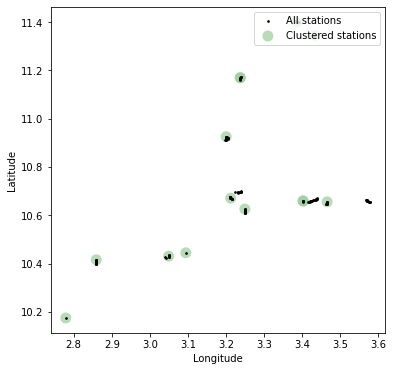

In [29]:
# plot all stations vs clustered stations
fig, ax = plt.subplots(figsize=[6, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(clip['lon'], clip['lat'], c='k', alpha=0.9, s=3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['All stations', 'Clustered stations'], loc='upper right')
plt.show()

In [30]:
# convert clustered dataframe to geodataframe
cluster = gpd.GeoDataFrame(rs, crs=crs, geometry=rs['geometry'])

<AxesSubplot:>

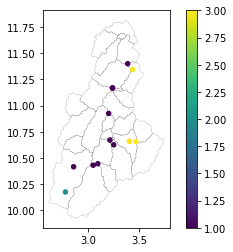

In [31]:
# plot sota sub basins and clipped points
base = subs.boundary.plot(color='black', linewidth=0.1)
cluster.plot(ax=base, column='pixel', markersize=20, legend=True, zorder=2)

In [32]:
# reproject road to EPSG:4326
road_crs = road.to_crs(crs)

In [33]:
# create forest column where stations gets value 1 if they are in forest with forest_id
cluster = gpd.sjoin(cluster, forest.loc[:, ['geometry']], how='left').assign(
    forest=lambda d: (~d['index_right'].isna()).astype(int)
)

In [34]:
# rename index_right column to forest_id
cluster = cluster.rename(columns={'index_right': 'forest_id'})

In [35]:
# swap 0 with 1 and 1 with 0 in forest column
cluster['forest'] =  np.where(cluster['forest'] == 1, 0, 1)

<AxesSubplot:>

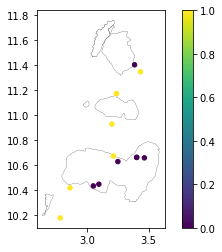

In [36]:
# plot stations with sota forests
base = forest.boundary.plot(color='black', linewidth=0.2)
cluster.plot(ax=base, column='forest', markersize=20, legend=True, zorder=2)

In [37]:
# add buffer to river intersection to easily find intersection with thhz coordinates
# add 500m buffer to road
road_buf = road
road_buf['buffered'] = road['geometry'].buffer(500)

In [38]:
# set buffered polygone as geometry
road_buf['geometry'] = road_buf['buffered']

In [39]:
# convert buffered road projection to EPSG:4326
road_buf = road_buf.to_crs(crs)

In [40]:
# create road column where stations gets value 1 if they are on road with road_id
cluster = gpd.sjoin(cluster, road_buf.loc[:, ['geometry']], how='left').assign(
    road=lambda d: (~d['index_right'].isna()).astype(int)
)

In [41]:
# rename index_right column to road_id
cluster = cluster.rename(columns={'index_right': 'road_id'})

<AxesSubplot:>

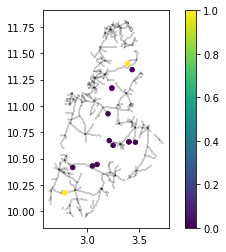

In [42]:
# plot stations with sota roads
base = road_buf.boundary.plot(color='black', linewidth=0.2)
cluster.plot(ax=base, column='road', markersize=20, legend=True, zorder=2)

In [43]:
cluster

,lon,lat,pixel,geometry,forest_id,forest,road_id,road
0,3.385338,11.400424,1,POINT (3.38534 11.40042),2.0,0,74.0,1
1,3.237338,11.169424,1,POINT (3.23734 11.16942),NaN,1,NaN,0
2,3.200338,10.925424,1,POINT (3.20034 10.92542),NaN,1,NaN,0
3,3.237338,11.169424,1,POINT (3.23734 11.16942),NaN,1,NaN,0
4,3.212338,10.670424,1,POINT (3.21234 10.67042),NaN,1,NaN,0
5,3.249338,10.625424,1,POINT (3.24934 10.62542),4.0,0,NaN,0
6,3.094338,10.444424,1,POINT (3.09434 10.44442),4.0,0,NaN,0
7,3.049338,10.430424,1,POINT (3.04934 10.43042),4.0,0,NaN,0
8,2.859338,10.415424,1,POINT (2.85934 10.41542),NaN,1,NaN,0
9,2.779338,10.174424,2,POINT (2.77934 10.17442),NaN,1,131.0,1


In [44]:
# priority stations from thhz pixel values, forest and road accessibility
cluster['priority'] = cluster['pixel'] + cluster['forest'] + cluster['road']

In [45]:
# show hydrological station dataframe
cluster

,lon,lat,pixel,geometry,forest_id,forest,road_id,road,priority
0,3.385338,11.400424,1,POINT (3.38534 11.40042),2.0,0,74.0,1,2
1,3.237338,11.169424,1,POINT (3.23734 11.16942),NaN,1,NaN,0,2
2,3.200338,10.925424,1,POINT (3.20034 10.92542),NaN,1,NaN,0,2
3,3.237338,11.169424,1,POINT (3.23734 11.16942),NaN,1,NaN,0,2
4,3.212338,10.670424,1,POINT (3.21234 10.67042),NaN,1,NaN,0,2
5,3.249338,10.625424,1,POINT (3.24934 10.62542),4.0,0,NaN,0,1
6,3.094338,10.444424,1,POINT (3.09434 10.44442),4.0,0,NaN,0,1
7,3.049338,10.430424,1,POINT (3.04934 10.43042),4.0,0,NaN,0,1
8,2.859338,10.415424,1,POINT (2.85934 10.41542),NaN,1,NaN,0,2
9,2.779338,10.174424,2,POINT (2.77934 10.17442),NaN,1,131.0,1,4


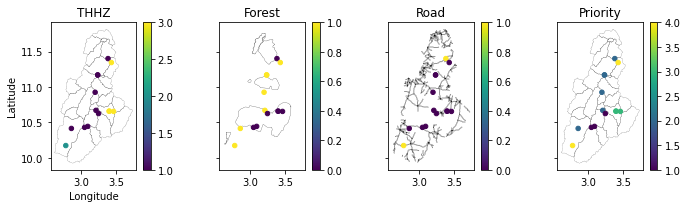

In [46]:
# summary plot
fig, axes = plt.subplots(1,4, figsize=(10,3), sharex=True, sharey=True)

base = subs.boundary.plot(color='black', linewidth=0.1, ax=axes[0])
cluster.plot(ax=base, column='pixel', markersize=20, legend=True, zorder=2)
axes[0].set_title('THHZ')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

axes[1].set_title('Forest')
base = forest.boundary.plot(color='black', linewidth=0.2, ax=axes[1])
cluster.plot(ax=base, column='forest', markersize=20, legend=True, zorder=2)

axes[2].set_title('Road')
base = road_buf.boundary.plot(color='black', linewidth=0.2, ax=axes[2])
cluster.plot(ax=base, column='road', markersize=20, legend=True, zorder=2)

axes[3].set_title('Priority')
base = subs.boundary.plot(color='black', linewidth=0.1, ax=axes[3])
cluster.plot(ax=base, column='priority', markersize=20, legend=True, zorder=2)

fig.tight_layout()

In [47]:
# save hydrological station dataframe
#cluster.to_file('./data/output/hydrological_station.shp')